In [1]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## NN libs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
import keras
from keras import regularizers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Activation, Conv1D, Conv2D, Dropout, Flatten
from keras.layers import Conv2DTranspose, Reshape, MaxPooling2D, UpSampling2D, UpSampling1D, MaxPooling1D
from keras.layers import LocallyConnected1D, LocallyConnected2D
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [4]:
context = data.init()

Setting up params

max min f 25.0 0.1
 >> Context(max_t=10.0, dt=0.02, n_instances=500, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)


## Setup a generator

1. What is the least amount of 'hidden' nodes needed to learn a straight rythm (e.g. 8th notes with different frequencies)
2. Can we create a model of a generic function sin(2 pi f t + phase)
    - using x: t -> y: sin(2p t)
    - using x: [f, t, phase] -> y: sin(2p f t + phase)
    - using x: sin([t1, t2, t3) -> y: [f, t, phase]
        - such a model should be able to learn complex patterns, such as sin(f1+p1) + sin(f2+p2) + sin(f3+p3)

In [5]:
n = 100
fs = np.repeat(1, n)
fs = None
x_train = g.gen_data(context, n, fs=fs)
# x_train = np.zeros([10,100,127])
y_train = x_train[:,-1]
x_train = x_train[:,:-1]

 [DEBUG] > 
 |>  min_f < max_f
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  10.009374999999999
 |>  500
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  to_array: msg.time > max_t; t, n
 |>  9.991666666666644
 |>  500
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 
 |>  WARNING
 |>  type not == 0
 [DEBUG] > 


In [6]:
x_train.shape

(100, 499, 4)

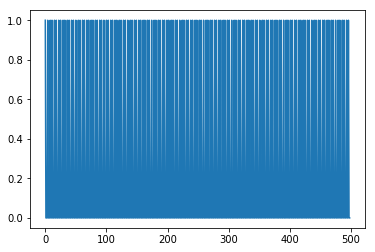

In [33]:
plt.plot(x_train[0,:,3])

In [8]:
n_samples = x_train[0]
input_shape = x_train.shape[1:] # shape of a single sample
output_shape = y_train[0].shape # shape of a single sample
# output_length = y_train.shape[1:][0]
hidden_layer_length = 10
input_shape

(499, 4)

In [9]:
output_shape

(4,)

In [10]:
def model(input_shape, output_shape):
    n_categories = input_shape[-1]
    print('n_categories =', n_categories)
#     input_layer = Input(shape=input_shape)
    # input shape = (None, None, 1)
    # thus: unfixed n samples, unfixed n timesteps, 1 float value
    input_layer = Input(shape=(None, n_categories))
    x = input_layer
    
    hidden_size = 128
    x = LSTM(128, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(hidden_size, return_state=False, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    
    w = np.prod(output_shape)
    print('w =',w)
    w = 100
    x = Dense(w, activation='relu')(x)

    x = Dense(np.prod(output_shape), activation='sigmoid')(x)
#     x = Reshape(output_shape)(x)
    model = Model(inputs=input_layer, outputs=x)
    return model

model = model(input_shape, output_shape)
model.summary()

n_categories = 4
w = 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 4)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_2 (Dense)              (None, 4)               

In [11]:
metrics = ['accuracy','mse','binary_crossentropy'] # sparse_categorical_accuracy
loss = 'categorical_crossentropy'# binary_crossentropy categorical_crossentropy sparse_categorical_crossentropy
optimizer = 'rmsprop' # adam adadelta rmsprop nadam
model.compile(optimizer=optimizer, loss=loss, metrics=['mse', 'mae'])#, metrics=metrics)

In [12]:
batch_size = 12
# n epochs = n iterations over all the training data
epochs = 6

In [13]:
# decoder.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_split=1/6, callbacks=[TensorBoard(log_dir=config.tmp_log_dir)])

Train on 83 samples, validate on 17 samples
Epoch 1/6
83/83 [==============================] - 5s 66ms/step - loss: 0.0831 - mean_squared_error: 0.2503 - mean_absolute_error: 0.5003 - val_loss: 0.0801 - val_mean_squared_error: 0.2491 - val_mean_absolute_error: 0.4990
Epoch 2/6
83/83 [==============================] - 5s 56ms/step - loss: 0.0814 - mean_squared_error: 0.2493 - mean_absolute_error: 0.4991 - val_loss: 0.0783 - val_mean_squared_error: 0.2492 - val_mean_absolute_error: 0.4989
Epoch 3/6
83/83 [==============================] - 5s 56ms/step - loss: 0.0795 - mean_squared_error: 0.2494 - mean_absolute_error: 0.4990 - val_loss: 0.0762 - val_mean_squared_error: 0.2492 - val_mean_absolute_error: 0.4984
Epoch 4/6
83/83 [==============================] - 5s 55ms/step - loss: 0.0768 - mean_squared_error: 0.2491 - mean_absolute_error: 0.4979 - val_loss: 0.0732 - val_mean_squared_error: 0.2486 - val_mean_absolute_error: 0.4964
Epoch 5/6
83/83 [==============================] - 5s 56ms/s

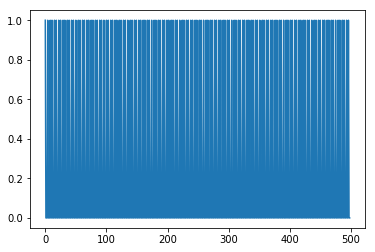

In [14]:
i = 0
# full = np.concatenate([x_test[i,-selection:],results[i]])
# n3 = full.shape[0]
plt.plot(x_train[0,:,3])

In [15]:
x = x_train[0,:250]
for _ in range(250):
    results = model.predict(np.stack([x[:]]))
    last_value = results[0]
    x = np.concatenate([x, [last_value]])
#     print(x[-3:])

In [16]:
x.shape

(500, 4)

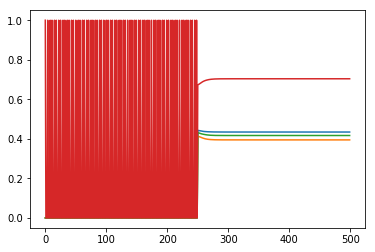

In [17]:
plt.plot(x[:,0:])

In [18]:
i = 2
selection = int(x_test.shape[1] * 1)
full = np.concatenate([x_test[i,-selection:],results[i]])
n3 = full.shape[0]
plt.plot(np.arange(n3) / n3 * dt, full)

NameError: name 'x_test' is not defined

In [ ]:
results = predict_point_by_point(encoder, x_train)
plt.plot(results[0])